In [31]:
import numpy as np
import pandas as pd
import darts
from darts import TimeSeries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, r2_score, rmse

from darts.models import (
    AutoARIMA,
    Prophet,
    RNNModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel,
    TransformerModel
)

import torch
from tqdm import tqdm
import numpy as np
from darts.utils.likelihood_models import QuantileRegression

In [32]:
df = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=['Date'])
df.sample(10)
df = pd.concat([df.drop(columns='StateHoliday'), pd.get_dummies(df.StateHoliday, prefix='Holiday')], axis=1)

In [33]:
store = pd.read_csv('../input/rossmann-store-sales/store.csv')

In [34]:
def get_sample(num):
    sample = df[df.Store == num]
    series = TimeSeries.from_dataframe(sample, 'Date', 'Sales')

    train, test = series.split_before(pd.Timestamp("20150601"))

    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    test_transformed = transformer.transform(test)

    series_customers = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Customers')
    series_open = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Open')
    series_promo = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Promo')
    series_school = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='SchoolHoliday')
    series_weekday = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='DayOfWeek')
    series_holiday_a = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_a')
    series_holiday_b = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_b')
    series_holiday_c = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_c')

    customers_transformed = transformer.transform(series_customers)

    covariates = series_customers.stack(series_open)
    covariates = covariates.stack(series_promo)
    covariates = covariates.stack(series_school)
    covariates = covariates.stack(series_weekday)
    covariates = covariates.stack(series_holiday_a)
    covariates = covariates.stack(series_holiday_b)
    covariates = covariates.stack(series_holiday_c)

    train_covariates, test_covariates = covariates.split_before(pd.Timestamp("20150601"))

    return train_transformed, test_transformed, covariates

In [35]:
train, test, covariates = get_sample(10)

In [36]:
cdf = df.groupby('Store').count().reset_index()[['Store', 'Date']]
store_merged = pd.merge(store, cdf, left_on='Store', right_on='Store')
store_merged = store_merged[store_merged.Date == 942]

In [41]:
def rmspe(actual, pred):
    return np.sqrt(np.mean( ((actual - pred) / actual)**2)) 

def smape(actual, pred):
    return np.mean(np.abs(pred - actual) / ((np.abs(actual) + np.abs(pred))/2)) * 100

def evaluate_model(model, train, test, covariates):
    model.fit(train, past_covariates=covariates)
    pred = model.predict(len(test), past_covariates=covariates)
    test = test.pd_dataframe()
    pred = pred.pd_dataframe()

    test.columns = ['Actual']
    pred.columns = ['Pred']

    df = pd.concat([test, pred], axis=1)
    df = df[df.Actual > 0]
    return smape(df.Actual.values, df.Pred.values), rmspe(df.Actual.values, df.Pred.values)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

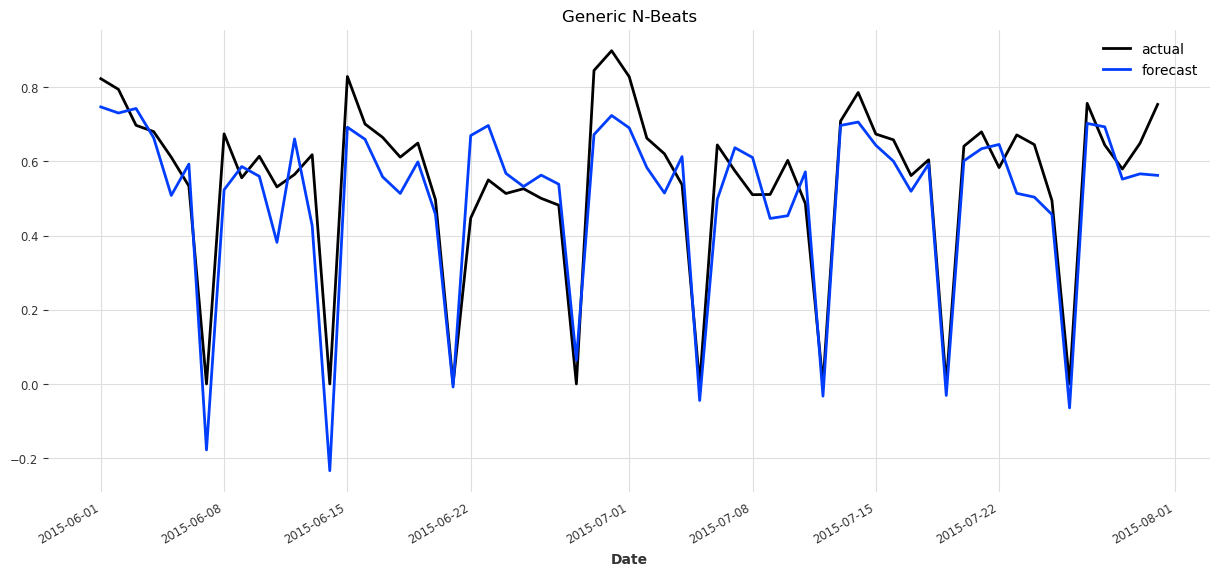

In [38]:
train_transformed, test_transformed, covariates = get_sample(10)
nbeats_model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_rossmann",
)

nbeats_model.fit(train_transformed)
pred_demand_covs = nbeats_model.predict(len(test_transformed))

plt.figure(figsize=(15, 6))
test_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title('Generic N-Beats')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


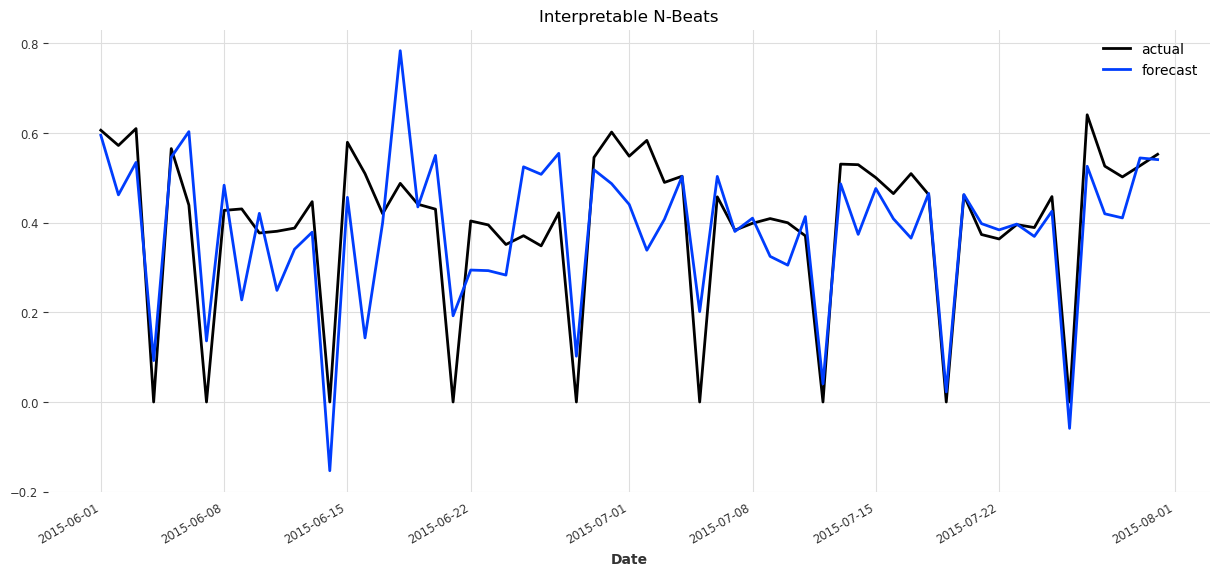

In [39]:
train_transformed, test_transformed, covariates = get_sample(1)
nbeats_model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=False,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=100,
    model_name="nbeats_interpretable_rossmann",
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0], "enable_progress_bar": False}
)

nbeats_model.fit(train_transformed, past_covariates=covariates)
pred_demand_covs = nbeats_model.predict(len(test_transformed), past_covariates=covariates)

plt.figure(figsize=(15, 6))
test_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title('Interpretable N-Beats')
plt.show()

In [40]:
store_num_list = pd.read_csv('../input/store_list.csv').Store.values
store_num_list

array([  10,   62,  110,  163,  300,  333,  388,  392,  448,  467,  486,
        489,  524,  549,  566,  632,  749,  765,  811,  826,  872,  880,
        883,  896,  913,  954,  956,  966, 1022, 1108,  259,  335,  353,
        423,  494,  562,  676,  682,  733,  769,   70,  130,  131,  208,
        321,  349,  382,  398,  442,  444,  474,  482,  499,  554,  595,
        654,  666,  678,  708,  747,  787,  854,  857,  860,  861,  968,
        978,  996, 1006, 1055,   31,   56,   75,   80,   94,  154,  261,
        291,  350,  356,  372,  424,  493,  521,  525,  578,  585,  601,
        605,  723,  740,  803,  850,  865,  940,  960, 1010, 1046, 1089,
       1101], dtype=int64)

### 1. Generic Architecture

In [14]:
smape_list = []
rmspe_list = []

for num in tqdm(store_num_list):
    train_transformed, test_transformed, covariates = get_sample(num)
    nbeats_model = NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=7,
        generic_architecture=True,
        num_stacks=10,
        num_blocks=1,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        nr_epochs_val_period=1,
        batch_size=100,
        model_name="nbeats_rossmann",
        pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0], "enable_progress_bar": False}
    )
    smape_score, rmspe_score = evaluate_model(nbeats_model, train_transformed, test_transformed, covariates)
    rmspe_list.append(rmspe_score)
    smape_list.append(smape_score)
    print(num, smape_score, rmspe_score)

  0%|          | 0/100 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  1%|          | 1/100 [01:27<2:24:10, 87.38s/it]GPU availa

10 17.419559306397975 0.2060788579169253


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  2%|▏         | 2/100 [02:56<2:24:05, 88.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


62 26.710963810797818 0.27576472629380866


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  3%|▎         | 3/100 [04:24<2:22:35, 88.20s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


110 30.434627911604075 0.32700842024758636


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  4%|▍         | 4/100 [05:52<2:20:50, 88.02s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


163 22.23852156392057 0.2450809335741114


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|▌         | 5/100 [07:18<2:18:39, 87.58s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


300 21.05689609879159 0.30515677205648


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  6%|▌         | 6/100 [08:46<2:17:21, 87.68s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


333 27.201979390573243 0.2916301357593242


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  7%|▋         | 7/100 [10:13<2:15:38, 87.52s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


388 29.942670123950325 0.37189780018454627


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  8%|▊         | 8/100 [11:40<2:13:51, 87.30s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


392 20.117635095893366 0.24901379771611246


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  9%|▉         | 9/100 [13:08<2:12:31, 87.38s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


448 18.31430132388942 0.23031502806245252


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|█         | 10/100 [14:35<2:10:49, 87.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


467 56.30978868308632 0.46804358902879317


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 11%|█         | 11/100 [16:01<2:09:00, 86.98s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


486 25.784359947587127 0.26658162671668983


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 12%|█▏        | 12/100 [17:29<2:07:48, 87.14s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


489 22.430456914814272 0.279245769478297


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 13%|█▎        | 13/100 [18:55<2:05:53, 86.82s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


524 26.44332299584244 0.3784334363522603


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 14%|█▍        | 14/100 [20:20<2:03:52, 86.43s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


549 12.78443289412379 0.15246380746498486


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 15%|█▌        | 15/100 [21:46<2:02:13, 86.27s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)


566 17.26201034901413 0.21518928260246756


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 16%|█▌        | 16/100 [23:16<2:02:15, 87.32s/it]

632 33.72828455212876 0.34914850293907396


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 17%|█▋        | 17/100 [24:59<2:07:26, 92.13s/it]GPU available: True (cuda), used: True


749 37.081185306406866 0.7460094305140906


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 18%|█▊        | 18/100 [26:45<2:11:29, 96.21s/it]

765 20.9649301409281 0.21696693474115233


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 19%|█▉        | 19/100 [28:29<2:12:54, 98.45s/it]

811 15.157192589145113 0.1661671337664684


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 20%|██        | 20/100 [30:12<2:13:04, 99.81s/it]

826 23.279055784968158 0.2978783837613127


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 21%|██        | 21/100 [32:20<2:22:33, 108.27s/it]

872 26.04035331377951 0.31231496721252927


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 22%|██▏       | 22/100 [34:03<2:18:49, 106.79s/it]

880 17.347463653643423 0.2031629340186652


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 23%|██▎       | 23/100 [35:51<2:17:27, 107.10s/it]

883 16.35016537908382 0.2031868392122964


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 24%|██▍       | 24/100 [37:33<2:13:59, 105.78s/it]

896 16.994538536931714 0.1956497721268623


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 25%|██▌       | 25/100 [39:21<2:12:58, 106.38s/it]

913 51.653047774564065 0.45787054104422836


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 26%|██▌       | 26/100 [41:04<2:09:58, 105.38s/it]

954 26.682903586800656 0.32846474044699375


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 27%|██▋       | 27/100 [42:51<2:08:35, 105.69s/it]

956 40.81895417651562 0.5436944933412946


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 28%|██▊       | 28/100 [44:37<2:07:01, 105.85s/it]

966 12.818116340317548 0.16412568177576076


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 29%|██▉       | 29/100 [46:21<2:04:29, 105.20s/it]

1022 36.40053360515275 0.4406984560624539


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 30%|███       | 30/100 [48:09<2:03:41, 106.02s/it]

1108 27.56812014905673 0.29427742774244137


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 31%|███       | 31/100 [49:51<2:00:42, 104.96s/it]

259 72.72702635871077 1.191662281678708


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 32%|███▏      | 32/100 [51:39<1:59:54, 105.81s/it]

335 60.717151467759045 0.6883112547375286


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 33%|███▎      | 33/100 [53:21<1:57:06, 104.87s/it]

353 50.30044059255009 0.5013762925259262


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 34%|███▍      | 34/100 [55:09<1:56:08, 105.58s/it]

423 61.42602219385158 0.690659058949893


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 35%|███▌      | 35/100 [56:53<1:54:02, 105.27s/it]

494 35.13513225716751 0.6957934262235669


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 36%|███▌      | 36/100 [58:38<1:51:57, 104.96s/it]

562 25.47421397695634 0.3365687112246728


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 37%|███▋      | 37/100 [1:00:24<1:50:45, 105.48s/it]

676 52.96182919357428 0.839738282747926


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 38%|███▊      | 38/100 [1:02:08<1:48:19, 104.83s/it]

682 71.14233791822532 0.8544067588189734


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 39%|███▉      | 39/100 [1:03:55<1:47:16, 105.52s/it]

733 35.42693412083067 0.42653838767410385


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 40%|████      | 40/100 [1:05:37<1:44:35, 104.60s/it]

769 65.20473031427454 0.5313258278972696


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 41%|████      | 41/100 [1:07:25<1:43:56, 105.71s/it]

70 25.34985801444692 0.2922361358224212


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 42%|████▏     | 42/100 [1:09:09<1:41:29, 104.99s/it]

130 14.82139548263831 0.1836697952426286


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 43%|████▎     | 43/100 [1:10:55<1:40:02, 105.30s/it]

131 22.247654593086473 0.25173905458409024


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 44%|████▍     | 44/100 [1:12:40<1:38:20, 105.36s/it]

208 18.06210938948766 0.21250072535889156


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 45%|████▌     | 45/100 [1:14:24<1:36:11, 104.93s/it]

321 29.727304827769984 0.43753682220542445


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 46%|████▌     | 46/100 [1:16:10<1:34:47, 105.32s/it]

349 30.457938296012948 0.3145514524408993


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 47%|████▋     | 47/100 [1:17:53<1:32:22, 104.57s/it]

382 19.868534986648044 0.23859220167479975


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 48%|████▊     | 48/100 [1:19:41<1:31:30, 105.59s/it]

398 33.93588770044009 0.36360694477102184


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 49%|████▉     | 49/100 [1:21:24<1:28:59, 104.69s/it]

442 22.471061155614645 0.2487345700504518


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 50%|█████     | 50/100 [1:23:12<1:28:04, 105.69s/it]

444 37.35307339159842 0.40075238735652013


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 51%|█████     | 51/100 [1:24:56<1:26:03, 105.39s/it]

474 14.128700433591558 0.19442485132636847


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 52%|█████▏    | 52/100 [1:26:42<1:24:13, 105.28s/it]

482 46.65127309111671 0.4672868126490672


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 53%|█████▎    | 53/100 [1:28:29<1:22:56, 105.88s/it]

499 22.846999641431022 0.23948379201656098


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 54%|█████▍    | 54/100 [1:30:12<1:20:36, 105.14s/it]

554 30.36650770300448 0.29223759699118346


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 55%|█████▌    | 55/100 [1:32:01<1:19:34, 106.10s/it]

595 104.11132280803612 1.182166712339524


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 56%|█████▌    | 56/100 [1:33:44<1:17:08, 105.19s/it]

654 25.781507852665314 0.2948506721032151


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 57%|█████▋    | 57/100 [1:35:32<1:16:00, 106.06s/it]

666 23.641894870158616 0.31150106920893156


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 58%|█████▊    | 58/100 [1:37:15<1:13:39, 105.22s/it]

678 25.464502674958528 0.278831354985696


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 59%|█████▉    | 59/100 [1:39:02<1:12:19, 105.85s/it]GPU available: True (cuda), used: True
TPU av

708 58.6372141834431 0.5720160445282514


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 60%|██████    | 60/100 [1:40:48<1:10:31, 105.79s/it]

747 28.054298073246088 0.32208849486775204


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 61%|██████    | 61/100 [1:42:32<1:08:30, 105.41s/it]

787 19.58160544396645 0.25603654492821787


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 62%|██████▏   | 62/100 [1:44:19<1:06:59, 105.79s/it]

854 22.37906600459449 0.26752965406792906


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 63%|██████▎   | 63/100 [1:46:02<1:04:38, 104.82s/it]

857 16.02160784657237 0.22414213512661613


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 64%|██████▍   | 64/100 [1:47:50<1:03:28, 105.80s/it]

860 32.07632024534848 0.36056642308104847


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 65%|██████▌   | 65/100 [1:49:33<1:01:11, 104.91s/it]

861 28.561660219631285 0.32433673006139896


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 66%|██████▌   | 66/100 [1:51:21<1:00:02, 105.95s/it]

968 17.120379825482235 0.2033108427235514


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 67%|██████▋   | 67/100 [1:53:05<57:52, 105.23s/it]  

978 37.53134485383704 0.3708589868762753


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 68%|██████▊   | 68/100 [1:54:50<56:07, 105.24s/it]

996 56.664486585986666 0.5828691873583932


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 69%|██████▉   | 69/100 [1:56:35<54:21, 105.21s/it]

1006 26.397380040180668 0.318102048499212


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 70%|███████   | 70/100 [1:58:18<52:20, 104.68s/it]

1055 50.707017202123815 0.4601230937837312


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 71%|███████   | 71/100 [2:00:05<50:57, 105.41s/it]

31 24.527830056351018 0.32240294977204664


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 72%|███████▏  | 72/100 [2:01:48<48:47, 104.56s/it]

56 23.72358409985399 0.25252452996906427


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 73%|███████▎  | 73/100 [2:03:36<47:33, 105.67s/it]

75 27.806533125536482 0.3069130203990242


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 74%|███████▍  | 74/100 [2:05:19<45:25, 104.84s/it]

80 16.09686835765345 0.20312480042695674


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 75%|███████▌  | 75/100 [2:07:07<44:00, 105.63s/it]

94 15.733491903587352 0.19021795839975322


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 76%|███████▌  | 76/100 [2:08:52<42:10, 105.44s/it]

154 19.562189660697133 0.22930676224322


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 77%|███████▋  | 77/100 [2:10:37<40:21, 105.26s/it]

261 35.76604432719215 0.40272092373562995


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 78%|███████▊  | 78/100 [2:12:24<38:51, 105.98s/it]

291 49.110911912260974 0.48519613491981906


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 79%|███████▉  | 79/100 [2:14:07<36:46, 105.06s/it]

350 25.359174760378245 0.27178396698125934


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 80%|████████  | 80/100 [2:15:55<35:18, 105.94s/it]

356 20.048858016062816 0.23347408627090058


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 81%|████████  | 81/100 [2:17:39<33:21, 105.35s/it]

372 31.147661349395882 0.304004178747151


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 82%|████████▏ | 82/100 [2:19:27<31:52, 106.24s/it]

424 24.453793751302204 0.2770994511821031


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 83%|████████▎ | 83/100 [2:21:11<29:51, 105.37s/it]

493 23.975526449578556 0.2564675777276796


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 84%|████████▍ | 84/100 [2:22:58<28:12, 105.79s/it]

521 14.279057509844806 0.1980546325008711


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 85%|████████▌ | 85/100 [2:24:43<26:27, 105.81s/it]

525 18.246812936212596 0.21564355180319508


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 86%|████████▌ | 86/100 [2:26:28<24:34, 105.35s/it]

578 19.550379653544 0.23020416436319385


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 87%|████████▋ | 87/100 [2:28:15<22:56, 105.91s/it]GPU available: True (cuda), used: True
TPU avai

585 44.70585857498015 0.4865872030357107



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 88%|████████▊ | 88/100 [2:29:58<20:59, 104.93s/it]

601 13.66591569447568 0.18697767030320164


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 89%|████████▉ | 89/100 [2:31:45<19:22, 105.68s/it]

605 21.14707127398455 0.21781210423581693


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 90%|█████████ | 90/100 [2:33:28<17:28, 104.90s/it]

723 28.817827453481936 0.27755027124008647


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 91%|█████████ | 91/100 [2:35:16<15:53, 105.89s/it]

740 18.122773562369364 0.20639155507895893


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 92%|█████████▏| 92/100 [2:37:00<14:02, 105.32s/it]

803 17.562245142475852 0.21496676828400257


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 93%|█████████▎| 93/100 [2:38:46<12:18, 105.56s/it]

850 41.27420478979497 0.44336215801570505


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 94%|█████████▍| 94/100 [2:40:33<10:35, 105.87s/it]

865 22.244835543319205 0.23719950570106454


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 95%|█████████▌| 95/100 [2:42:16<08:45, 105.06s/it]

940 22.487859733849536 0.2549544552935387


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 96%|█████████▌| 96/100 [2:44:04<07:03, 105.88s/it]

960 25.086724211867505 0.26623465164061627


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 97%|█████████▋| 97/100 [2:45:47<05:14, 104.99s/it]

1010 39.37005964916232 0.3509052250046768


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 98%|█████████▊| 98/100 [2:47:35<03:32, 106.02s/it]

1046 19.232445025882267 0.27488379058999396


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 99%|█████████▉| 99/100 [2:49:18<01:45, 105.15s/it]

1089 25.885390360488515 0.2861761934360797


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.3 M 
---------------------------------------------------
9.3 M     Trainable params
4.2 K     Non-trainable params
9.3 M     Total params
74.708    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
100%|██████████| 100/100 [2:51:06<00:00, 102.66s/it]

1101 19.671400757896183 0.27785062876347544


29.975354267742073 15.457894639940426 104.11132280803612 12.78443289412379


(array([32., 38., 12.,  5.,  6.,  4.,  2.,  0.,  0.,  1.]),
 array([ 12.78443289,  21.91712189,  31.04981088,  40.18249987,
         49.31518886,  58.44787785,  67.58056684,  76.71325583,
         85.84594483,  94.97863382, 104.11132281]),
 <BarContainer object of 10 artists>)

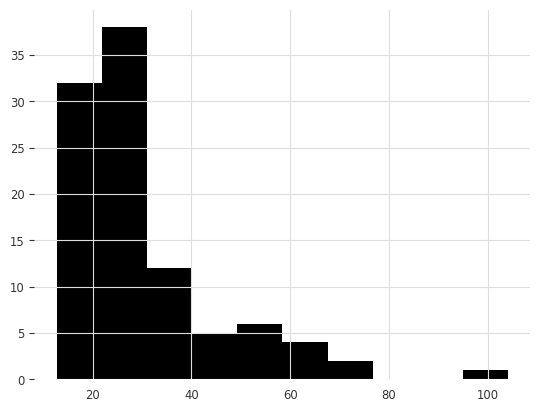

In [15]:
print(np.mean(smape_list), np.std(smape_list), np.max(smape_list), np.min(smape_list))
plt.hist(smape_list)

0.34765574511733893 0.18728537004789628 1.191662281678708 0.15246380746498486


(array([36., 34., 13.,  7.,  2.,  4.,  2.,  0.,  0.,  2.]),
 array([0.15246381, 0.25638365, 0.3603035 , 0.46422335, 0.5681432 ,
        0.67206304, 0.77598289, 0.87990274, 0.98382259, 1.08774243,
        1.19166228]),
 <BarContainer object of 10 artists>)

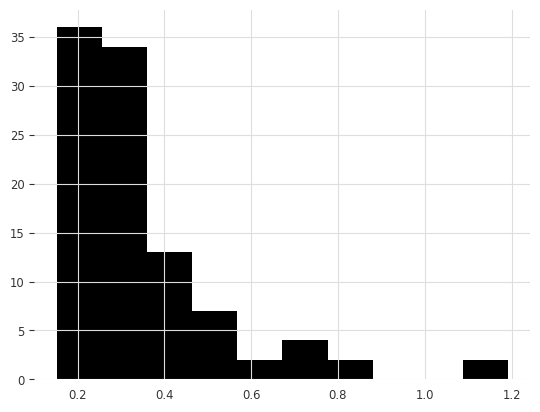

In [16]:
print(np.mean(rmspe_list), np.std(rmspe_list), np.max(rmspe_list), np.min(rmspe_list))
plt.hist(rmspe_list)

In [17]:
res1 = pd.DataFrame(
    {
        'rmspe' : rmspe_list,
        'smape' : smape_list,
    }
)

### 1.2  Interpretable Model

In [18]:
smape_list = []
rmspe_list = []

for num in tqdm(store_num_list):
    train_transformed, test_transformed, covariates = get_sample(num)
    nbeats_model = NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=7,
        generic_architecture=False,
        num_stacks=10,
        num_blocks=1,
        num_layers=4,
        layer_widths=512,
        n_epochs=100,
        nr_epochs_val_period=1,
        batch_size=100,
        model_name="nbeats_interpretable_rossmann",
        pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0], "enable_progress_bar": False}
    )
    smape_score, rmspe_score = evaluate_model(nbeats_model, train_transformed, test_transformed, covariates)
    rmspe_list.append(rmspe_score)
    smape_list.append(smape_score)
    print(num, smape_score, rmspe_score)

  0%|          | 0/100 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  1%|          | 1/100 [00:37<1:02:15, 37.73s/it]GPU availa

10 29.155541523914675 0.27752811626029933


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  2%|▏         | 2/100 [01:15<1:01:17, 37.53s/it]GPU available: True (cuda), used: True


62 20.71584858343522 0.24956104483291325


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  3%|▎         | 3/100 [01:50<59:25, 36.75s/it]  GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

110 22.902965867538974 0.2980385318565773


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  4%|▍         | 4/100 [02:26<58:14, 36.40s/it]GPU available: True (cuda), used: True


163 19.499906522601062 0.24420036270420045


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|▌         | 5/100 [03:04<58:16, 36.80s/it]GPU available: True (cuda), used: True


300 48.89883942515817 0.4326611390110705


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  6%|▌         | 6/100 [03:42<58:36, 37.41s/it]

333 22.564439299791026 0.32502653180565944


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  7%|▋         | 7/100 [04:21<58:20, 37.63s/it]GPU available: True (cuda), used: True


388 26.589617300809838 0.2890512974594781


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  8%|▊         | 8/100 [04:58<57:40, 37.61s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU availa

392 18.343544573116645 0.26930175773522524



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  9%|▉         | 9/100 [05:35<56:47, 37.45s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


448 21.78160756494219 0.24953679297618167



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|█         | 10/100 [06:10<54:57, 36.64s/it]GPU available: True (cuda), used: True


467 37.71898460294194 0.46833885291766486


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 11%|█         | 11/100 [06:48<54:49, 36.96s/it]

486 37.60040030292088 0.38192663851944314


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 12%|█▏        | 12/100 [07:26<54:46, 37.34s/it]GPU available: True (cuda), used: True
TPU availab

489 29.178921876735618 0.3565785194281066


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 13%|█▎        | 13/100 [08:05<54:44, 37.75s/it]GPU available: True (cuda), used: True


524 45.873369643614495 0.6647966280761055


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 14%|█▍        | 14/100 [08:42<54:02, 37.71s/it]GPU available: True (cuda), used: True


549 16.183203656062243 0.203015420840414


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 15%|█▌        | 15/100 [09:19<53:14, 37.58s/it]

566 18.527608766342336 0.2130300946839951


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 16%|█▌        | 16/100 [09:55<51:46, 36.99s/it]GPU available: True (cuda), used: True
TPU availab

632 39.5471075189565 0.42342033356946324


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 17%|█▋        | 17/100 [10:31<50:41, 36.65s/it]

749 23.30210448741397 0.48279632408127615


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 18%|█▊        | 18/100 [11:09<50:28, 36.93s/it]

765 15.067806540555969 0.19884601504945487


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 19%|█▉        | 19/100 [11:47<50:37, 37.50s/it]GPU available: True (cuda), used: True


811 19.377637552830496 0.274804271902744


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 20%|██        | 20/100 [12:26<50:18, 37.74s/it]GPU available: True (cuda), used: True


826 20.989586000221838 0.24700001123672766


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 21%|██        | 21/100 [13:03<49:23, 37.52s/it]GPU available: True (cuda), used: True


872 24.310697426851068 0.27035450075428497


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 22%|██▏       | 22/100 [13:39<48:18, 37.15s/it]GPU available: True (cuda), used: True


880 16.909779731398807 0.2382733559527517


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 23%|██▎       | 23/100 [14:14<46:50, 36.50s/it]

883 20.296255359662638 0.2477510025673345


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 24%|██▍       | 24/100 [14:52<46:44, 36.91s/it]GPU available: True (cuda), used: True
TPU availab

896 49.68804786937161 0.46393193747388717


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 25%|██▌       | 25/100 [15:30<46:36, 37.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


913 18.847699577279865 0.2861180365804431


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 26%|██▌       | 26/100 [16:09<46:29, 37.70s/it]

954 25.542954288393677 0.3143560728560476


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 27%|██▋       | 27/100 [16:46<45:37, 37.51s/it]GPU available: True (cuda), used: True
TPU availab

956 34.53770287908179 0.410089496327554


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 28%|██▊       | 28/100 [17:23<44:55, 37.43s/it]GPU available: True (cuda), used: True


966 19.368181652104727 0.20850424546923754


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 29%|██▉       | 29/100 [17:58<43:34, 36.83s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

1022 33.12292837810782 0.38404401556391465


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 30%|███       | 30/100 [18:35<42:44, 36.64s/it]GPU available: True (cuda), used: True


1108 21.430948882853812 0.28255642861523744


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 31%|███       | 31/100 [19:12<42:30, 36.97s/it]

259 47.26059184271818 0.5572945480144912


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 32%|███▏      | 32/100 [19:51<42:24, 37.41s/it]GPU available: True (cuda), used: True
TPU availab

335 149.57914283387584 1.364919898790346


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 33%|███▎      | 33/100 [20:29<41:59, 37.60s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available:

353 32.50090281518049 0.33739665989069395


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 34%|███▍      | 34/100 [21:06<41:15, 37.51s/it]

423 101.92587197637786 0.8984303832044487


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 35%|███▌      | 35/100 [21:42<40:16, 37.18s/it]GPU available: True (cuda), used: True
TPU availab

494 25.035798170461966 0.4317285988828326



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 36%|███▌      | 36/100 [22:17<38:55, 36.49s/it]

562 150.1118893048856 2.0301794073234216


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 37%|███▋      | 37/100 [22:55<38:41, 36.85s/it]GPU available: True (cuda), used: True


676 43.394640859010536 0.42655771923154545


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 38%|███▊      | 38/100 [23:33<38:32, 37.31s/it]GPU available: True (cuda), used: True


682 33.251235035202406 0.5219206903451314


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 39%|███▉      | 39/100 [24:12<38:16, 37.65s/it]

733 123.31856429435221 3.515690444133225


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 40%|████      | 40/100 [24:49<37:35, 37.58s/it]

769 54.96481262289707 1.0867060587900061


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 41%|████      | 41/100 [25:27<36:51, 37.49s/it]

70 36.27321930825021 0.4074513138432589


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 42%|████▏     | 42/100 [26:02<35:34, 36.80s/it]GPU available: True (cuda), used: True


130 15.777868679336734 0.18898293421876544


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 43%|████▎     | 43/100 [26:38<34:52, 36.71s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

131 15.538544708101954 0.18903953890846237


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 44%|████▍     | 44/100 [27:16<34:32, 37.02s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


208 16.55404397893064 0.20600704139746837



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 45%|████▌     | 45/100 [27:55<34:20, 37.47s/it]

321 26.19238787582672 0.2722300535523142


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 46%|████▌     | 46/100 [28:32<33:47, 37.55s/it]GPU available: True (cuda), used: True


349 23.231351338274415 0.36778798099201965


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 47%|████▋     | 47/100 [29:10<33:04, 37.45s/it]

382 29.814787936724617 0.32089510155154644


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 48%|████▊     | 48/100 [29:46<32:05, 37.03s/it]GPU available: True (cuda), used: True
TPU availab

398 18.972791134777125 0.261372816098197


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 49%|████▉     | 49/100 [30:21<31:04, 36.55s/it]GPU available: True (cuda), used: True


442 17.95740865423807 0.22420253259600217


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 50%|█████     | 50/100 [30:59<30:46, 36.93s/it]

444 57.00280514918855 0.5708750901934652


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 51%|█████     | 51/100 [31:37<30:29, 37.34s/it]GPU available: True (cuda), used: True


474 27.397872363899843 0.3096553736582408


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 52%|█████▏    | 52/100 [32:16<30:10, 37.71s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

482 55.734496681600554 0.5181204621841419



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 53%|█████▎    | 53/100 [32:53<29:24, 37.55s/it]GPU available: True (cuda), used: True


499 21.97311900712407 0.24040305213369761


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 54%|█████▍    | 54/100 [33:30<28:39, 37.37s/it]

554 18.378607090533997 0.2166683579391634


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 55%|█████▌    | 55/100 [34:05<27:33, 36.74s/it]GPU available: True (cuda), used: True


595 45.76722875250855 0.5299344227428041


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 56%|█████▌    | 56/100 [34:42<26:59, 36.80s/it]GPU available: True (cuda), used: True


654 28.6498321117446 0.28957359567819363


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 57%|█████▋    | 57/100 [35:20<26:34, 37.07s/it]GPU available: True (cuda), used: True


666 21.61170381880205 0.2738026939391874


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 58%|█████▊    | 58/100 [35:58<26:14, 37.49s/it]GPU available: True (cuda), used: True


678 29.586966306388206 0.44108841926689707


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 59%|█████▉    | 59/100 [36:36<25:39, 37.55s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

708 35.099760528115965 0.40122835144779395


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 60%|██████    | 60/100 [37:13<24:59, 37.49s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


747 28.833275680126842 0.30735029669416675



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 61%|██████    | 61/100 [37:49<24:05, 37.05s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


787 29.424898595465613 0.3529563682526748


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 62%|██████▏   | 62/100 [38:25<23:10, 36.58s/it]GPU available: True (cuda), used: True


854 20.962119025080124 0.24370448066788267


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 63%|██████▎   | 63/100 [39:02<22:45, 36.90s/it]GPU available: True (cuda), used: True


857 26.728558433049066 0.34409526256744905


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 64%|██████▍   | 64/100 [39:41<22:21, 37.27s/it]GPU available: True (cuda), used: True


860 49.4951492132856 0.41999505478270355


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 65%|██████▌   | 65/100 [40:19<21:57, 37.65s/it]

861 15.07758414632917 0.1889339854254775


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 66%|██████▌   | 66/100 [40:56<21:16, 37.54s/it]

968 23.04328319095275 0.26055076049410897


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 67%|██████▋   | 67/100 [41:33<20:31, 37.33s/it]GPU available: True (cuda), used: True
TPU availab

978 25.670941255934377 0.2796010621284122



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 68%|██████▊   | 68/100 [42:08<19:34, 36.69s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


996 25.830884998449744 0.31449864001536



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 69%|██████▉   | 69/100 [42:46<19:03, 36.89s/it]GPU available: True (cuda), used: True


1006 28.028155873382417 0.3214965018759716


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 70%|███████   | 70/100 [43:24<18:37, 37.24s/it]GPU available: True (cuda), used: True


1055 40.67391192634908 0.4621435649023593


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 71%|███████   | 71/100 [44:03<18:13, 37.71s/it]

31 15.968011699835657 0.19875414463179


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 72%|███████▏  | 72/100 [44:40<17:34, 37.66s/it]GPU available: True (cuda), used: True
TPU availab

56 18.21493366021154 0.21735303982681936


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 73%|███████▎  | 73/100 [45:18<16:55, 37.62s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


75 23.78330390633406 0.2728041057864321


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 74%|███████▍  | 74/100 [45:54<16:05, 37.13s/it]

80 16.670580797538133 0.2307871133482276


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 75%|███████▌  | 75/100 [46:30<15:20, 36.84s/it]GPU available: True (cuda), used: True


94 24.450058261339823 0.31646551140080814


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 76%|███████▌  | 76/100 [47:08<14:51, 37.16s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

154 21.880624237519942 0.2943728304684797


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 77%|███████▋  | 77/100 [47:46<14:22, 37.50s/it]GPU available: True (cuda), used: True


261 37.775435123164435 0.4175342844766848


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 78%|███████▊  | 78/100 [48:25<13:51, 37.81s/it]

291 30.538295358314727 0.4528317210071525


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 79%|███████▉  | 79/100 [49:02<13:09, 37.59s/it]GPU available: True (cuda), used: True
TPU availab

350 24.09704311050659 0.29450119178446377


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 80%|████████  | 80/100 [49:38<12:25, 37.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available:

356 15.750561715728725 0.18120024850799424


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 81%|████████  | 81/100 [50:13<11:35, 36.58s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Nam

372 38.71113118973615 0.36577882659912514


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 82%|████████▏ | 82/100 [50:51<11:03, 36.88s/it]GPU available: True (cuda), used: True


424 27.042126586226225 0.3400860276420555


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 83%|████████▎ | 83/100 [51:29<10:34, 37.29s/it]

493 29.198421050481738 0.363147234056833


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 84%|████████▍ | 84/100 [52:08<10:03, 37.69s/it]

521 21.525345919538623 0.24076180725349466


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 85%|████████▌ | 85/100 [52:45<09:23, 37.58s/it]GPU available: True (cuda), used: True


525 16.93091189546227 0.20410547608508867


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 86%|████████▌ | 86/100 [53:22<08:45, 37.50s/it]

578 74.7320085631969 0.580770199481976


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 87%|████████▋ | 87/100 [53:58<07:59, 36.92s/it]GPU available: True (cuda), used: True


585 26.144254287266683 0.31935378931911457


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 88%|████████▊ | 88/100 [54:34<07:20, 36.73s/it]GPU available: True (cuda), used: True


601 19.96805330380219 0.23512265573410354


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 89%|████████▉ | 89/100 [55:12<06:46, 36.99s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

605 20.510593784660493 0.2477777672561091


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 90%|█████████ | 90/100 [55:51<06:15, 37.59s/it]GPU available: True (cuda), used: True


723 23.99655651565298 0.2573757704671103


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 91%|█████████ | 91/100 [56:29<05:39, 37.75s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

740 12.726557522094078 0.1620676229393869


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 92%|█████████▏| 92/100 [57:06<05:01, 37.65s/it]GPU available: True (cuda), used: True


803 17.346956839299793 0.2141862327405592


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 93%|█████████▎| 93/100 [57:43<04:20, 37.28s/it]GPU available: True (cuda), used: True


850 39.241427236365055 0.43536870139484285


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 94%|█████████▍| 94/100 [58:18<03:39, 36.64s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avail

865 16.210432310667162 0.1850648061562975



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 95%|█████████▌| 95/100 [58:56<03:04, 37.00s/it]

940 18.816056590819908 0.21918602018610855


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 96%|█████████▌| 96/100 [59:34<02:29, 37.45s/it]GPU available: True (cuda), used: True
TPU availab

960 14.698156376511204 0.1859701623376303



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 97%|█████████▋| 97/100 [1:00:13<01:53, 37.97s/it]GPU available: True (cuda), used: True


1010 19.505041423950004 0.2633819096090328


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 98%|█████████▊| 98/100 [1:00:51<01:15, 37.75s/it]

1046 15.649824503658927 0.24257108257954435


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 99%|█████████▉| 99/100 [1:01:28<00:37, 37.59s/it]

1089 32.2948329102906 0.3160190461684142


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 2.1 M 
---------------------------------------------------
1.9 M     Trainable params
215 K     Non-trainable params
2.1 M     Total params
16.826    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
100%|██████████| 100/100 [1:02:03<00:00, 37.24s/it]

1101 19.87352917606307 0.2911793424220505


31.487523110289814 23.565433368664063 150.1118893048856 12.726557522094078


(array([57., 27.,  8.,  3.,  1.,  0.,  1.,  0.,  1.,  2.]),
 array([ 12.72655752,  26.4650907 ,  40.20362388,  53.94215706,
         67.68069024,  81.41922341,  95.15775659, 108.89628977,
        122.63482295, 136.37335613, 150.1118893 ]),
 <BarContainer object of 10 artists>)

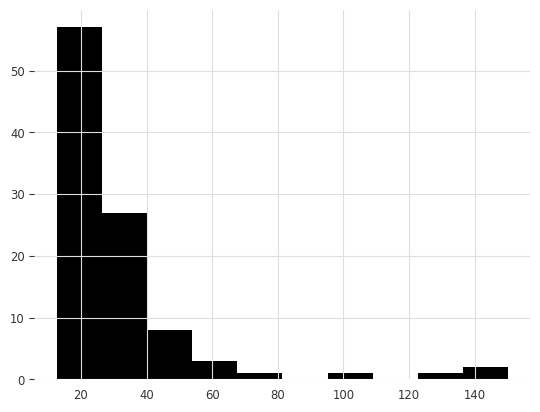

In [19]:
print(np.mean(smape_list), np.std(smape_list), np.max(smape_list), np.min(smape_list))
plt.hist(smape_list)

0.39096785967529746 0.39640183907859206 3.515690444133225 0.1620676229393869


(array([88.,  7.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([0.16206762, 0.49742991, 0.83279219, 1.16815447, 1.50351675,
        1.83887903, 2.17424132, 2.5096036 , 2.84496588, 3.18032816,
        3.51569044]),
 <BarContainer object of 10 artists>)

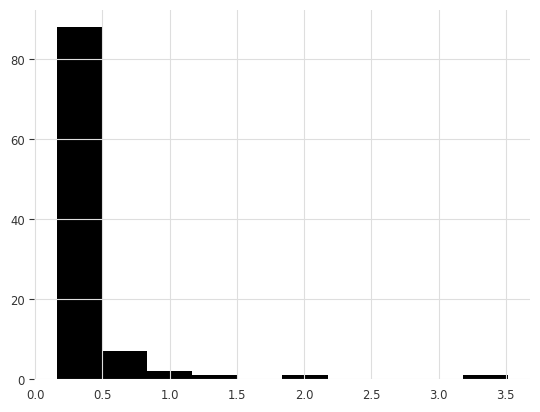

In [20]:
print(np.mean(rmspe_list), np.std(rmspe_list), np.max(rmspe_list), np.min(rmspe_list))
plt.hist(rmspe_list)

In [21]:
res2 = pd.DataFrame(
    {
        'rmspe' : rmspe_list,
        'smape' : smape_list,
    }
)

### 1.3 Result Comparison

In [22]:
res1['Store'] = store_num_list
res2['Store'] = store_num_list

result = pd.merge(res1, res2, left_on='Store', right_on='Store')
result = result.set_index('Store')
result = pd.merge(result, store[['Store','StoreType']], left_on='Store', right_on='Store')
result.to_csv('../output/nbeats_results.csv')
result.head(10)

Store   rmspe_x    smape_x   rmspe_y    smape_y StoreType
0     10  0.206079  17.419559  0.277528  29.155542         a
1     62  0.275765  26.710964  0.249561  20.715849         a
2    110  0.327008  30.434628  0.298039  22.902966         a
3    163  0.245081  22.238522  0.244200  19.499907         a
4    300  0.305157  21.056896  0.432661  48.898839         a
5    333  0.291630  27.201979  0.325027  22.564439         a
6    388  0.371898  29.942670  0.289051  26.589617         a
7    392  0.249014  20.117635  0.269302  18.343545         a
8    448  0.230315  18.314301  0.249537  21.781608         a
9    467  0.468044  56.309789  0.468339  37.718985         a

In [ ]:
res1.mean()

In [ ]:
res2.mean()

## Hyperparameter

In [23]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection, SymmetricMeanAbsolutePercentageError

In [24]:
from darts.utils.likelihood_models import GaussianLikelihood

def train_model(model_args, callbacks, train, val, covariates):
    torch_metrics = MetricCollection([SymmetricMeanAbsolutePercentageError()])
    # Create the model using model_args from Ray Tune
    model = NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=7,
        generic_architecture=True,
        layer_widths=512,
        n_epochs=100,
        nr_epochs_val_period=1,
        model_name="nbeats_rossmann",
        torch_metrics=torch_metrics,
        pl_trainer_kwargs = {"callbacks": callbacks, "enable_progress_bar": False},
        **model_args)

    model.fit(
        series=train,
        val_series=val,
        past_covariates=covariates,
        val_past_covariates=covariates
    )

In [25]:
train, test, covariates = get_sample(10)
train, val = train.split_after(pd.Timestamp(year=2015, month=4, day=1))

In [26]:
my_stopper = EarlyStopping(
    monitor="val_SymmetricMeanAbsolutePercentageError",
    patience=5,
    min_delta=0.05,
    mode='min',
)

# set up ray tune callback
tune_callback = TuneReportCallback(
    {
        "loss": "val_Loss",
        "SMAPE": "val_SymmetricMeanAbsolutePercentageError",
    },
    on="validation_end",
)

# define the hyperparameter space
config = {
    "batch_size": tune.choice([16, 32, 64, 128]),
    "num_blocks": tune.choice([1, 2, 3, 4, 5]),
    "num_stacks": tune.choice([32, 64, 128]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "SMAPE", "training_iteration"],
)

resources_per_trial = {"cpu": 16, "gpu": 1}

# the number of combinations to try
num_samples = 10

scheduler = ASHAScheduler(max_t=1000, grace_period=3, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(
    train_model, callbacks=[my_stopper, tune_callback], train=train, val=val, covariates=covariates
)

# optimize hyperparameters by minimizing the MAPE on the validation set
analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    # Using a metric instead of loss allows for
    # comparison between different likelihood or loss functions.
    metric="SMAPE",  # any value in TuneReportCallback.
    mode="min",
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_darts",
)

print("Best hyperparameters found were: ", analysis.best_config)

2023-01-31 07:16:42,389	INFO worker.py:1538 -- Started a local Ray instance.


== Status ==
Current time: 2023-01-31 07:16:45 (running for 00:00:00.26)
Memory usage on this node: 15.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |
|-------------------------+----------+----------------+--------------+--------------+--------------|
| train_model_29a2b_00000 | RUNNING  | 127.0.0.1:9320 |           64 |            5 |           32 |
| train_model_29a2b_00001 | PENDING  |                |           16 

(train_model pid=9320) GPU available: True (cuda), used: False
(train_model pid=9320) TPU available: False, using: 0 TPU cores
(train_model pid=9320) IPU available: False, using: 0 IPUs
(train_model pid=9320) HPU available: False, using: 0 HPUs
(train_model pid=9320) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=9320)   rank_zero_warn(
(train_model pid=9320) 
(train_model pid=9320)   | Name          | Type             | Params
(train_model pid=9320) ---------------------------------------------------
(train_model pid=9320) 0 | criterion     | MSELoss          | 0     
(train_model pid=9320) 1 | train_metrics | MetricCollection | 0     
(train_model pid=9320) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=9320) 3 | stacks        | ModuleList       | 149 M 
(train_model pid=9320) -

== Status ==
Current time: 2023-01-31 07:16:55 (running for 00:00:10.37)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |
|-------------------------+----------+----------------+--------------+--------------+--------------|
| train_model_29a2b_00000 | RUNNING  | 127.0.0.1:9320 |           64 |            5 |           32 |
| train_model_29a2b_00001 | PENDING  |                |           16 

(train_model pid=9320) 2023-01-31 07:19:12,783	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:19:17 (running for 00:02:32.92)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.7921263751936365 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+----------------+--------------+----

(train_model pid=9320) 2023-01-31 07:21:26,998	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:21:32 (running for 00:04:47.12)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.8776828920278528 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+----------------+--------------+----

(train_model pid=9320) 2023-01-31 07:23:46,531	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:23:51 (running for 00:07:06.62)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.7411025258385653 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+----------------+----

(train_model pid=9320) 2023-01-31 07:26:03,013	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:26:08 (running for 00:09:23.10)
Memory usage on this node: 21.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.5797840964101777 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+----------------+----

(train_model pid=9320) 2023-01-31 07:28:17,975	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:28:23 (running for 00:11:38.07)
Memory usage on this node: 21.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.5123980133740578 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+----------------+----

(train_model pid=9320) 2023-01-31 07:30:36,418	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:30:41 (running for 00:13:56.53)
Memory usage on this node: 21.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3654603942418542 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+------

(train_model pid=9320) 2023-01-31 07:32:51,478	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:32:56 (running for 00:16:11.61)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.247646670263281 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+-------

(train_model pid=9320) 2023-01-31 07:35:14,605	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:35:19 (running for 00:18:34.71)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.226896574487206 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+-------

(train_model pid=9320) 2023-01-31 07:37:33,623	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:37:38 (running for 00:20:53.72)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.1641265685004778 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+------

(train_model pid=9320) 2023-01-31 07:39:51,230	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:39:56 (running for 00:23:11.34)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.1696932857563378 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+------

(train_model pid=9320) 2023-01-31 07:42:06,479	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:42:11 (running for 00:25:26.60)
Memory usage on this node: 20.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: None | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.1095582149617438 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+----------+------

(train_model pid=9320) 2023-01-31 07:44:21,048	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:44:26 (running for 00:27:41.17)
Memory usage on this node: 20.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.0778101703879102 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+--

(train_model pid=9320) 2023-01-31 07:46:42,457	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:46:47 (running for 00:30:02.53)
Memory usage on this node: 21.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=0.9983023715470877 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|-------------------------+

(train_model pid=9320) 2023-01-31 07:49:00,244	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:49:05 (running for 00:32:20.35)
Memory usage on this node: 21.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=0.9904004250542674 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+--

(train_model pid=9320) 2023-01-31 07:51:19,856	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:51:24 (running for 00:34:39.94)
Memory usage on this node: 21.1/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.1043729272249792 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+--

(train_model pid=9320) 2023-01-31 07:53:32,779	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:53:37 (running for 00:36:52.88)
Memory usage on this node: 21.1/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.268254419968495 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+---

(train_model pid=9320) 2023-01-31 07:55:50,091	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:55:55 (running for 00:39:10.20)
Memory usage on this node: 21.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.4979409034383142 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-------------------------+----------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status   | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+--

(train_model pid=9320) 2023-01-31 07:58:05,022	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 07:58:11 (running for 00:41:26.07)
Memory usage on this node: 16.5/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=8824) GPU available: True (cuda), used: False
(train_model pid=8824) TPU available: False, using: 0 TPU cores
(train_model pid=8824) IPU available: False, using: 0 IPUs
(train_model pid=8824) HPU available: False, using: 0 HPUs
(train_model pid=8824) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=8824)   rank_zero_warn(
(train_model pid=8824) 
(train_model pid=8824)   | Name          | Type             | Params
(train_model pid=8824) ---------------------------------------------------
(train_model pid=8824) 0 | criterion     | MSELoss          | 0     
(train_model pid=8824) 1 | train_metrics | MetricCollection | 0     
(train_model pid=8824) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=8824) 3 | stacks        | ModuleList       | 358 M 
(train_model pid=8824) -

== Status ==
Current time: 2023-01-31 07:58:16 (running for 00:41:31.13)
Memory usage on this node: 21.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=8824) 2023-01-31 08:13:24,740	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 08:13:29 (running for 00:56:44.85)
Memory usage on this node: 27.3/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=8824) 2023-01-31 08:28:55,548	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 08:29:00 (running for 01:12:15.63)
Memory usage on this node: 27.3/31.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------------+------------+----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc            |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=8824) 2023-01-31 08:44:28,551	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 08:44:34 (running for 01:27:49.08)
Memory usage on this node: 16.5/31.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.758383777656142
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=34300) GPU available: True (cuda), used: False
(train_model pid=34300) TPU available: False, using: 0 TPU cores
(train_model pid=34300) IPU available: False, using: 0 IPUs
(train_model pid=34300) HPU available: False, using: 0 HPUs
(train_model pid=34300) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=34300)   rank_zero_warn(
(train_model pid=34300) 
(train_model pid=34300)   | Name          | Type             | Params
(train_model pid=34300) ---------------------------------------------------
(train_model pid=34300) 0 | criterion     | MSELoss          | 0     
(train_model pid=34300) 1 | train_metrics | MetricCollection | 0     
(train_model pid=34300) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=34300) 3 | stacks        | ModuleList       | 478 M 
(train_mode

== Status ==
Current time: 2023-01-31 08:44:39 (running for 01:27:54.25)
Memory usage on this node: 20.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.758383777656142
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=34300) 2023-01-31 08:52:08,768	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 08:52:13 (running for 01:35:28.89)
Memory usage on this node: 30.1/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.758383777656142
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------

(train_model pid=34300) 2023-01-31 08:59:14,891	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 08:59:19 (running for 01:42:34.99)
Memory usage on this node: 29.9/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.758383777656142
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------

(train_model pid=34300) 2023-01-31 09:06:28,117	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:06:33 (running for 01:49:48.24)
Memory usage on this node: 29.8/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------

(train_model pid=34300) 2023-01-31 09:13:42,982	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:13:48 (running for 01:57:03.09)
Memory usage on this node: 29.8/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------

(train_model pid=34300) 2023-01-31 09:20:58,413	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:21:03 (running for 02:04:18.53)
Memory usage on this node: 29.7/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------

(train_model pid=34300) 2023-01-31 09:28:17,975	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:28:23 (running for 02:11:38.98)
Memory usage on this node: 14.7/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) GPU available: True (cuda), used: False
(train_model pid=9588) TPU available: False, using: 0 TPU cores
(train_model pid=9588) IPU available: False, using: 0 IPUs
(train_model pid=9588) HPU available: False, using: 0 HPUs
(train_model pid=9588) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=9588)   rank_zero_warn(
(train_model pid=9588) 
(train_model pid=9588)   | Name          | Type             | Params
(train_model pid=9588) ---------------------------------------------------
(train_model pid=9588) 0 | criterion     | MSELoss          | 0     
(train_model pid=9588) 1 | train_metrics | MetricCollection | 0     
(train_model pid=9588) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=9588) 3 | stacks        | ModuleList       | 119 M 
(train_model pid=9588) -

== Status ==
Current time: 2023-01-31 09:28:30 (running for 02:11:45.76)
Memory usage on this node: 18.4/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:30:16,740	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:30:21 (running for 02:13:36.84)
Memory usage on this node: 18.5/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:32:05,443	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:32:10 (running for 02:15:25.52)
Memory usage on this node: 18.4/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:33:55,014	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:34:00 (running for 02:17:15.14)
Memory usage on this node: 18.5/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:35:46,235	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:35:51 (running for 02:19:06.33)
Memory usage on this node: 18.4/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:37:31,500	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:37:36 (running for 02:20:51.60)
Memory usage on this node: 18.6/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00000 with SMAPE=1.3444665548417118 and parameters={'batch_size': 64, 'num_blocks': 5, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:39:17,168	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:39:22 (running for 02:22:37.25)
Memory usage on this node: 18.5/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.3374299899861741 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:40:59,678	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:41:04 (running for 02:24:19.77)
Memory usage on this node: 18.6/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.3336155633712756 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:42:51,937	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:42:56 (running for 02:26:12.02)
Memory usage on this node: 18.6/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.1834740089126143 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:44:37,030	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:44:42 (running for 02:27:57.13)
Memory usage on this node: 18.5/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.180219470591949 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=9588) 2023-01-31 09:46:02,738	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:46:07 (running for 02:29:22.82)
Memory usage on this node: 19.4/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.0984024382588256 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:46:39,552	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:46:44 (running for 02:29:59.66)
Memory usage on this node: 19.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0778101703879102 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.0026239222255182 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=9588) 2023-01-31 09:47:16,293	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:47:21 (running for 02:30:37.02)
Memory usage on this node: 15.4/31.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=11576) GPU available: True (cuda), used: False
(train_model pid=11576) TPU available: False, using: 0 TPU cores
(train_model pid=11576) IPU available: False, using: 0 IPUs
(train_model pid=11576) HPU available: False, using: 0 HPUs
(train_model pid=11576) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=11576)   rank_zero_warn(
(train_model pid=11576) 
(train_model pid=11576)   | Name          | Type             | Params
(train_model pid=11576) ---------------------------------------------------
(train_model pid=11576) 0 | criterion     | MSELoss          | 0     
(train_model pid=11576) 1 | train_metrics | MetricCollection | 0     
(train_model pid=11576) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=11576) 3 | stacks        | ModuleList       | 149 M 
(train_mode

== Status ==
Current time: 2023-01-31 09:47:27 (running for 02:30:42.32)
Memory usage on this node: 20.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=11576) 2023-01-31 09:49:49,028	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:49:54 (running for 02:33:09.15)
Memory usage on this node: 20.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=11576) 2023-01-31 09:52:15,179	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:52:20 (running for 02:35:35.29)
Memory usage on this node: 20.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=11576) 2023-01-31 09:54:48,549	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:54:53 (running for 02:38:08.64)
Memory usage on this node: 20.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=11576) 2023-01-31 09:57:19,341	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:57:24 (running for 02:40:39.41)
Memory usage on this node: 20.3/31.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=11576) 2023-01-31 09:59:42,495	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 09:59:47 (running for 02:43:02.56)
Memory usage on this node: 20.6/31.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=11576) 2023-01-31 10:02:22,221	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:02:27 (running for 02:45:42.59)
Memory usage on this node: 26.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=2832) GPU available: True (cuda), used: False
(train_model pid=2832) TPU available: False, using: 0 TPU cores
(train_model pid=2832) IPU available: False, using: 0 IPUs
(train_model pid=2832) HPU available: False, using: 0 HPUs
(train_model pid=2832) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=2832)   rank_zero_warn(
(train_model pid=2832) 
(train_model pid=2832)   | Name          | Type             | Params
(train_model pid=2832) ---------------------------------------------------
(train_model pid=2832) 0 | criterion     | MSELoss          | 0     
(train_model pid=2832) 1 | train_metrics | MetricCollection | 0     
(train_model pid=2832) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=2832) 3 | stacks        | ModuleList       | 119 M 
(train_model pid=2832) -

== Status ==
Current time: 2023-01-31 10:02:34 (running for 02:45:49.43)
Memory usage on this node: 30.0/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------

(train_model pid=2832) 2023-01-31 10:02:58,736	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:03:03 (running for 02:46:18.84)
Memory usage on this node: 29.7/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------

(train_model pid=2832) 2023-01-31 10:03:26,051	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:03:31 (running for 02:46:46.13)
Memory usage on this node: 29.7/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------

(train_model pid=2832) 2023-01-31 10:03:52,346	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:03:58 (running for 02:47:13.22)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=34416) GPU available: True (cuda), used: False
(train_model pid=34416) TPU available: False, using: 0 TPU cores
(train_model pid=34416) IPU available: False, using: 0 IPUs
(train_model pid=34416) HPU available: False, using: 0 HPUs
(train_model pid=34416) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=34416)   rank_zero_warn(
(train_model pid=34416) 
(train_model pid=34416)   | Name          | Type             | Params
(train_model pid=34416) ---------------------------------------------------
(train_model pid=34416) 0 | criterion     | MSELoss          | 0     
(train_model pid=34416) 1 | train_metrics | MetricCollection | 0     
(train_model pid=34416) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=34416) 3 | stacks        | ModuleList       | 89.6 M
(train_mode

== Status ==
Current time: 2023-01-31 10:04:03 (running for 02:47:18.26)
Memory usage on this node: 28.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=34416) 2023-01-31 10:04:18,689	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:04:23 (running for 02:47:38.76)
Memory usage on this node: 28.1/31.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=34416) 2023-01-31 10:04:39,204	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:04:44 (running for 02:47:59.27)
Memory usage on this node: 28.2/31.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=34416) 2023-01-31 10:04:59,204	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:04:59 (running for 02:48:14.58)
Memory usage on this node: 24.5/31.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=6404) GPU available: True (cuda), used: False
(train_model pid=6404) TPU available: False, using: 0 TPU cores
(train_model pid=6404) IPU available: False, using: 0 IPUs
(train_model pid=6404) HPU available: False, using: 0 HPUs
(train_model pid=6404) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=6404)   rank_zero_warn(
(train_model pid=6404) 
(train_model pid=6404)   | Name          | Type             | Params
(train_model pid=6404) ---------------------------------------------------
(train_model pid=6404) 0 | criterion     | MSELoss          | 0     
(train_model pid=6404) 1 | train_metrics | MetricCollection | 0     
(train_model pid=6404) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=6404) 3 | stacks        | ModuleList       | 119 M 
(train_model pid=6404) -

== Status ==
Current time: 2023-01-31 10:05:09 (running for 02:48:24.52)
Memory usage on this node: 28.5/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------

(train_model pid=6404) 2023-01-31 10:06:11,881	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:06:16 (running for 02:49:31.97)
Memory usage on this node: 28.5/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------

(train_model pid=6404) 2023-01-31 10:07:17,838	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:07:22 (running for 02:50:37.91)
Memory usage on this node: 28.7/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7411025258385653
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------

(train_model pid=6404) 2023-01-31 10:08:21,763	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:08:26 (running for 02:51:41.84)
Memory usage on this node: 28.6/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------

(train_model pid=6404) 2023-01-31 10:09:23,191	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:09:28 (running for 02:52:43.26)
Memory usage on this node: 28.7/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------

(train_model pid=6404) 2023-01-31 10:10:26,749	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:10:31 (running for 02:53:46.82)
Memory usage on this node: 27.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.4548768216185226 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00007 with SMAPE=1.1034938823959868 and parameters={'batch_size': 32, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=6404) 2023-01-31 10:11:31,578	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:11:36 (running for 02:54:51.64)
Memory usage on this node: 28.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00007 with SMAPE=1.0922247298593624 and parameters={'batch_size': 32, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=6404) 2023-01-31 10:12:37,065	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:12:42 (running for 02:55:57.14)
Memory usage on this node: 27.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00007 with SMAPE=0.9660985589835732 and parameters={'batch_size': 32, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|------

(train_model pid=6404) 2023-01-31 10:13:38,442	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:13:43 (running for 02:56:58.50)
Memory usage on this node: 28.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00007 with SMAPE=1.06329163111698 and parameters={'batch_size': 32, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=6404) 2023-01-31 10:14:36,969	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:14:42 (running for 02:57:57.05)
Memory usage on this node: 28.1/31.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00007 with SMAPE=0.9517341145714 and parameters={'batch_size': 32, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|---------

(train_model pid=6404) 2023-01-31 10:15:42,461	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:15:47 (running for 02:59:02.58)
Memory usage on this node: 28.3/31.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00007 with SMAPE=1.0021978216027156 and parameters={'batch_size': 32, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------

(train_model pid=6404) 2023-01-31 10:16:50,003	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:16:55 (running for 03:00:10.06)
Memory usage on this node: 28.5/31.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00007 with SMAPE=0.9714424708333053 and parameters={'batch_size': 32, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+----------------

(train_model pid=6404) 2023-01-31 10:17:58,887	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:18:04 (running for 03:01:19.28)
Memory usage on this node: 24.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=35156) GPU available: True (cuda), used: False
(train_model pid=35156) TPU available: False, using: 0 TPU cores
(train_model pid=35156) IPU available: False, using: 0 IPUs
(train_model pid=35156) HPU available: False, using: 0 HPUs
(train_model pid=35156) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=35156)   rank_zero_warn(
(train_model pid=35156) 
(train_model pid=35156)   | Name          | Type             | Params
(train_model pid=35156) ---------------------------------------------------
(train_model pid=35156) 0 | criterion     | MSELoss          | 0     
(train_model pid=35156) 1 | train_metrics | MetricCollection | 0     
(train_model pid=35156) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=35156) 3 | stacks        | ModuleList       | 89.6 M
(train_mode

== Status ==
Current time: 2023-01-31 10:18:09 (running for 03:01:24.45)
Memory usage on this node: 27.6/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=35156) 2023-01-31 10:18:54,836	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:18:59 (running for 03:02:14.92)
Memory usage on this node: 27.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=35156) 2023-01-31 10:19:47,721	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:19:52 (running for 03:03:07.80)
Memory usage on this node: 27.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7231558134316334
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=35156) 2023-01-31 10:20:39,754	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:20:44 (running for 03:03:59.81)
Memory usage on this node: 27.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=35156) 2023-01-31 10:21:32,851	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:21:37 (running for 03:04:52.92)
Memory usage on this node: 27.6/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0451347777620255 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------

(train_model pid=35156) 2023-01-31 10:22:23,741	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:22:28 (running for 03:05:43.80)
Memory usage on this node: 27.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3654603942418542 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|----------

(train_model pid=35156) 2023-01-31 10:23:13,936	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:23:18 (running for 03:06:34.01)
Memory usage on this node: 27.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-----------

(train_model pid=35156) 2023-01-31 10:24:04,334	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:24:09 (running for 03:07:24.40)
Memory usage on this node: 27.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-----------

(train_model pid=35156) 2023-01-31 10:24:57,126	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:25:02 (running for 03:08:17.18)
Memory usage on this node: 28.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00003 with SMAPE=1.114913612011441 and parameters={'batch_size': 64, 'num_blocks': 4, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-----------

(train_model pid=35156) 2023-01-31 10:25:47,521	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:25:47 (running for 03:09:02.64)
Memory usage on this node: 27.7/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.7052091010247015
Resources requested: 0/20 CPUs, 0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 PENDING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|-------------------------+

(train_model pid=21580) GPU available: True (cuda), used: False
(train_model pid=21580) TPU available: False, using: 0 TPU cores
(train_model pid=21580) IPU available: False, using: 0 IPUs
(train_model pid=21580) HPU available: False, using: 0 HPUs
(train_model pid=21580) c:\Users\daeky\miniconda3\envs\darts\lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
(train_model pid=21580)   rank_zero_warn(
(train_model pid=21580) 
(train_model pid=21580)   | Name          | Type             | Params
(train_model pid=21580) ---------------------------------------------------
(train_model pid=21580) 0 | criterion     | MSELoss          | 0     
(train_model pid=21580) 1 | train_metrics | MetricCollection | 0     
(train_model pid=21580) 2 | val_metrics   | MetricCollection | 0     
(train_model pid=21580) 3 | stacks        | ModuleList       | 29.9 M
(train_mode

== Status ==
Current time: 2023-01-31 10:25:57 (running for 03:09:12.95)
Memory usage on this node: 25.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------------------

(train_model pid=21580) 2023-01-31 10:26:00,021	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:05 (running for 03:09:20.08)
Memory usage on this node: 25.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------------------

(train_model pid=21580) 2023-01-31 10:26:06,890	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:11 (running for 03:09:26.98)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.7052091010247015
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------------------

(train_model pid=21580) 2023-01-31 10:26:13,978	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:19 (running for 03:09:34.05)
Memory usage on this node: 25.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------------------

(train_model pid=21580) 2023-01-31 10:26:20,770	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:25 (running for 03:09:40.85)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------------------

(train_model pid=21580) 2023-01-31 10:26:27,903	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:32 (running for 03:09:47.97)
Memory usage on this node: 26.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.351445192114014 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|---------------------

(train_model pid=21580) 2023-01-31 10:26:34,967	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:40 (running for 03:09:55.05)
Memory usage on this node: 26.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------------------

(train_model pid=21580) 2023-01-31 10:26:42,139	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:47 (running for 03:10:02.21)
Memory usage on this node: 26.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00008 with SMAPE=1.0546115073743696 and parameters={'batch_size': 32, 'num_blocks': 3, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|--------------------

(train_model pid=21580) 2023-01-31 10:26:49,069	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:26:54 (running for 03:10:09.16)
Memory usage on this node: 26.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.8386769088109373 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|-----------------

(train_model pid=21580) 2023-01-31 10:26:56,296	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:01 (running for 03:10:16.35)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.9726863236396762 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|-----------------

(train_model pid=21580) 2023-01-31 10:27:03,666	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:08 (running for 03:10:23.76)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.8012665922250223 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|-----------------

(train_model pid=21580) 2023-01-31 10:27:11,294	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:16 (running for 03:10:31.37)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.114913612011441 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.9737764378321639 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|-----------------

(train_model pid=21580) 2023-01-31 10:27:18,351	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:23 (running for 03:10:38.43)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.9360603140004571 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|------------------

(train_model pid=21580) 2023-01-31 10:27:25,331	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:30 (running for 03:10:45.40)
Memory usage on this node: 26.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.7570823807566839 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|----------------

(train_model pid=21580) 2023-01-31 10:27:32,731	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:37 (running for 03:10:52.82)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.7444296205687838 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+---------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |   SMAPE |   training_iteration |
|------------------

(train_model pid=21580) 2023-01-31 10:27:40,697	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:45 (running for 03:11:00.76)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.7717078934507539 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|----------------

(train_model pid=21580) 2023-01-31 10:27:48,315	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:27:53 (running for 03:11:08.42)
Memory usage on this node: 25.9/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.8918459125137147 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|----------------

(train_model pid=21580) 2023-01-31 10:27:55,310	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.


== Status ==
Current time: 2023-01-31 10:28:00 (running for 03:11:15.39)
Memory usage on this node: 26.0/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 16.0/20 CPUs, 1.0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.7975588218153051 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|----------------

(train_model pid=21580) 2023-01-31 10:28:02,294	WARNING pytorch_lightning.py:134 -- Metric val_Loss does not exist in `trainer.callback_metrics.
2023-01-31 10:28:02,488	INFO tune.py:762 -- Total run time: 11477.56 seconds (11477.36 seconds for the tuning loop).


== Status ==
Current time: 2023-01-31 10:28:02 (running for 03:11:17.39)
Memory usage on this node: 25.8/31.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -1.0963618911996755 | Iter 6.000: -1.3374299899861741 | Iter 3.000: -1.6723801232769309
Resources requested: 0/20 CPUs, 0/1 GPUs, 0.0/10.14 GiB heap, 0.0/5.07 GiB objects
Current best trial: 29a2b_00009 with SMAPE=0.8002492889152683 and parameters={'batch_size': 128, 'num_blocks': 1, 'num_stacks': 32}
Result logdir: C:\Users\daeky\ray_results\tune_darts
Number of trials: 10/10 (10 TERMINATED)
+-------------------------+------------+-----------------+--------------+--------------+--------------+----------+----------------------+
| Trial name              | status     | loc             |   batch_size |   num_blocks |   num_stacks |    SMAPE |   training_iteration |
|-------------------------+-----

In [28]:
smape_list = []
rmspe_list = []

for num in tqdm(store_num_list):
    train_transformed, test_transformed, covariates = get_sample(num)
    nbeats_model = NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=7,
        generic_architecture=True,
        num_stacks=32,
        num_blocks=1,
        layer_widths=512,
        n_epochs=32,
        nr_epochs_val_period=1,
        batch_size=128,
        model_name="nbeats_rossmann",
        pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0], "enable_progress_bar": False}
    )
    smape_score, rmspe_score = evaluate_model(nbeats_model, train_transformed, test_transformed, covariates)
    rmspe_list.append(rmspe_score)
    smape_list.append(smape_score)
    print(num, smape_score, rmspe_score)

  0%|          | 0/100 [00:00<?, ?it/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  1%|          | 1/100 [01:18<2:09:14, 78.33s/it]

10 16.919708568143722 0.20397506652181865


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  2%|▏         | 2/100 [02:37<2:08:45, 78.84s/it]GPU available: True (cuda), used: True
TPU availab

62 29.746877253016514 0.35108685160817776


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  3%|▎         | 3/100 [03:55<2:07:07, 78.64s/it]

110 83.85327701462282 0.7521567944869023


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  4%|▍         | 4/100 [05:10<2:03:11, 76.99s/it]

163 26.66971902132582 0.3544949308365888


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  5%|▌         | 5/100 [08:32<3:13:29, 122.21s/it]

300 27.586259232010228 0.33224444899644323


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  6%|▌         | 6/100 [18:50<7:35:29, 290.74s/it]GPU available: True (cuda), used: True


333 32.53592839885919 0.4060013486110174


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  7%|▋         | 7/100 [20:14<5:45:36, 222.97s/it]GPU available: True (cuda), used: True


388 41.598557518580414 0.41647427720610863


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  8%|▊         | 8/100 [21:29<4:29:36, 175.83s/it]

392 26.698579907394336 0.3819374374532953


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
  9%|▉         | 9/100 [22:44<3:38:56, 144.36s/it]GPU available: True (cuda), used: True
TPU availa

448 41.75819627066348 0.40882821471694986


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 10%|█         | 10/100 [23:58<3:04:07, 122.75s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


467 47.800754470175235 0.533992686167469


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 11%|█         | 11/100 [25:12<2:40:06, 107.94s/it]

486 25.291086122505853 0.3084500730973944


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 12%|█▏        | 12/100 [26:27<2:23:37, 97.92s/it] 

489 40.94356647607535 0.5864732533541576


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 13%|█▎        | 13/100 [27:42<2:11:31, 90.71s/it]GPU available: True (cuda), used: True
TPU availa

524 68.00324318339005 0.7672986138429143


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 14%|█▍        | 14/100 [28:57<2:03:20, 86.05s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


549 21.82611586011224 0.24380460498847917


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 15%|█▌        | 15/100 [30:12<1:57:08, 82.69s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


566 15.96245216446249 0.20107531878819218


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 16%|█▌        | 16/100 [31:27<1:52:38, 80.46s/it]

632 110.49238434774398 0.8412825112489958


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 17%|█▋        | 17/100 [32:43<1:49:25, 79.10s/it]GPU available: True (cuda), used: True
TPU availa

749 69.46509147054046 1.022776210073115



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 18%|█▊        | 18/100 [33:59<1:47:00, 78.30s/it]GPU available: True (cuda), used: True


765 54.46716499799833 0.6186425730568373


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 19%|█▉        | 19/100 [35:16<1:45:02, 77.81s/it]GPU available: True (cuda), used: True


811 30.296354803401947 0.32337834917044217


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 20%|██        | 20/100 [36:32<1:43:08, 77.36s/it]

826 38.18983364733294 0.5509050948533939


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 21%|██        | 21/100 [37:50<1:41:47, 77.31s/it]GPU available: True (cuda), used: True
TPU availa

872 82.12873327620672 0.8192270325114382


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 22%|██▏       | 22/100 [39:06<1:40:19, 77.17s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


880 75.5756842027673 0.6668450509355401



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 23%|██▎       | 23/100 [40:22<1:38:22, 76.66s/it]

883 22.867144899361914 0.26890607700676383


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 24%|██▍       | 24/100 [41:39<1:37:07, 76.67s/it]GPU available: True (cuda), used: True


896 51.51960676982156 0.5311894484210103


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 25%|██▌       | 25/100 [42:54<1:35:29, 76.39s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

913 31.138260488397663 0.4224969102422819


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 26%|██▌       | 26/100 [44:10<1:33:53, 76.13s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


954 96.66906568714052 0.9695884428179341


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 27%|██▋       | 27/100 [45:26<1:32:38, 76.14s/it]

956 72.13646770035092 0.925363438492595


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 28%|██▊       | 28/100 [46:42<1:31:15, 76.05s/it]

966 24.035022039687824 0.3009664229282484


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 29%|██▉       | 29/100 [47:58<1:30:02, 76.10s/it]GPU available: True (cuda), used: True
TPU availa

1022 21.21285422185166 0.2862071447821163


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 30%|███       | 30/100 [49:15<1:28:56, 76.24s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


1108 26.457186697204566 0.3595107137636069


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 31%|███       | 31/100 [50:31<1:27:38, 76.22s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


259 75.42428851021944 1.3895127165209415


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 32%|███▏      | 32/100 [51:47<1:26:22, 76.21s/it]GPU available: True (cuda), used: True


335 54.65641313666488 0.8662818801710046


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 33%|███▎      | 33/100 [53:03<1:25:07, 76.23s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

353 109.03265381903147 1.1651954349640457


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 34%|███▍      | 34/100 [54:20<1:23:55, 76.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


423 106.52159017661998 1.5068924056657


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 35%|███▌      | 35/100 [55:37<1:22:49, 76.46s/it]

494 144.95261397760902 2.4642411051158946


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 36%|███▌      | 36/100 [56:54<1:21:47, 76.68s/it]

562 151.33724385316 7.025685500698506


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 37%|███▋      | 37/100 [58:10<1:20:30, 76.68s/it]GPU available: True (cuda), used: True
TPU availa

676 150.1829847252611 2.816362393578182


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 38%|███▊      | 38/100 [59:27<1:19:13, 76.66s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


682 152.41335147878016 11.744893676136234


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 39%|███▉      | 39/100 [1:00:42<1:17:33, 76.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


733 154.65510853497543 2.9307223393481276


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 40%|████      | 40/100 [1:01:58<1:16:13, 76.22s/it]GPU available: True (cuda), used: True


769 115.26828999901481 2.1133505308937584


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 41%|████      | 41/100 [1:03:15<1:14:57, 76.23s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU av

70 44.290308310248996 0.6374200849298735


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 42%|████▏     | 42/100 [1:04:30<1:13:28, 76.00s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


130 24.049350307806304 0.2648557577962833


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 43%|████▎     | 43/100 [1:05:46<1:12:08, 75.93s/it]

131 65.95543757916663 0.7609649909717043


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 44%|████▍     | 44/100 [1:07:02<1:10:49, 75.88s/it]GPU available: True (cuda), used: True


208 24.88375603342099 0.2667800630077041


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 45%|████▌     | 45/100 [1:08:17<1:09:25, 75.73s/it]GPU available: True (cuda), used: True


321 32.88044166277718 0.4205890055260269


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 46%|████▌     | 46/100 [1:09:33<1:08:12, 75.79s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


349 32.32014596648631 0.40324928628007967


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 47%|████▋     | 47/100 [1:10:49<1:07:05, 75.95s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU availab

382 24.8230468994805 0.34653237191991404


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 48%|████▊     | 48/100 [1:12:05<1:05:51, 76.00s/it]GPU available: True (cuda), used: True


398 67.85779645602824 0.740567851550494


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 49%|████▉     | 49/100 [1:13:22<1:04:37, 76.02s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU av

442 63.173683618281316 0.8157750764016697


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 50%|█████     | 50/100 [1:14:37<1:03:16, 75.94s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


444 48.91996368312571 0.7199158171533373


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 51%|█████     | 51/100 [1:15:54<1:02:06, 76.06s/it]

474 34.4793831034796 0.4117875330610399


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 52%|█████▏    | 52/100 [1:17:09<1:00:44, 75.93s/it]GPU available: True (cuda), used: True


482 114.10241262142115 0.9192953319046911


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 53%|█████▎    | 53/100 [1:18:25<59:25, 75.85s/it]  GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU av

499 29.512473718057482 0.3089888222869316


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 54%|█████▍    | 54/100 [1:19:40<58:02, 75.71s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


554 25.754557097477065 0.32672200420893055


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 55%|█████▌    | 55/100 [1:20:56<56:41, 75.60s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


595 48.689743595478916 0.6235957975676529


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 56%|█████▌    | 56/100 [1:22:11<55:26, 75.60s/it]GPU available: True (cuda), used: True


654 33.17777508451494 0.4466757474291538


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 57%|█████▋    | 57/100 [1:23:27<54:18, 75.77s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

666 39.18360767392047 0.3975968724965315


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 58%|█████▊    | 58/100 [1:24:43<52:54, 75.58s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


678 44.023720689000484 0.4385517337966534


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 59%|█████▉    | 59/100 [1:25:58<51:31, 75.40s/it]GPU available: True (cuda), used: True


708 151.47938588802617 1.6627164104502081


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 60%|██████    | 60/100 [1:27:14<50:28, 75.70s/it]

747 28.613516858415416 0.3411956776785827


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 61%|██████    | 61/100 [1:28:36<50:22, 77.50s/it]GPU available: True (cuda), used: True
TPU availa

787 31.68848733515669 0.4954978769344015


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 62%|██████▏   | 62/100 [1:29:56<49:37, 78.35s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


854 60.76077242316086 0.6160847056807013


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 63%|██████▎   | 63/100 [1:31:12<47:53, 77.67s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


857 25.154795092555183 0.3223811408368604


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 64%|██████▍   | 64/100 [1:32:27<46:09, 76.94s/it]GPU available: True (cuda), used: True


860 42.29129018956884 0.5239157384794504


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 65%|██████▌   | 65/100 [1:33:43<44:38, 76.54s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

861 31.498334383368952 0.35137057764625673


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 66%|██████▌   | 66/100 [1:34:59<43:13, 76.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


968 23.29552199691703 0.289992985106227


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 67%|██████▋   | 67/100 [1:36:14<41:49, 76.05s/it]

978 37.03799113559775 0.4307832459184072


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 68%|██████▊   | 68/100 [1:37:30<40:28, 75.88s/it]GPU available: True (cuda), used: True


996 46.172947347073645 0.5922187333497374


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 69%|██████▉   | 69/100 [1:38:46<39:16, 76.03s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

1006 25.879328383291707 0.31871936056317907


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 70%|███████   | 70/100 [1:40:03<38:05, 76.20s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


1055 25.405731013243464 0.3218120060585269


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 71%|███████   | 71/100 [1:41:19<36:50, 76.24s/it]GPU available: True (cuda), used: True


31 23.112157848907284 0.3050595188546242


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 72%|███████▏  | 72/100 [1:42:35<35:32, 76.18s/it]

56 47.61719126130266 0.5208904127973847


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 73%|███████▎  | 73/100 [1:43:51<34:20, 76.30s/it]GPU available: True (cuda), used: True
TPU availa

75 18.957239196511576 0.2564674101957474


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 74%|███████▍  | 74/100 [1:45:08<33:03, 76.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


80 20.702911747046286 0.2735303646713814


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 75%|███████▌  | 75/100 [1:46:24<31:45, 76.24s/it]

94 45.320517948505284 0.43433847974011297


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 76%|███████▌  | 76/100 [1:47:40<30:28, 76.20s/it]GPU available: True (cuda), used: True


154 27.7032375106937 0.32183518387783855


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 77%|███████▋  | 77/100 [1:48:56<29:11, 76.17s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

261 76.89790863876725 0.7921792405545884



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 78%|███████▊  | 78/100 [1:50:12<27:56, 76.20s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


291 33.50154433418443 0.5228273089617306


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 79%|███████▉  | 79/100 [1:51:28<26:37, 76.06s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


350 23.635401353687925 0.386561617149123


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 80%|████████  | 80/100 [1:52:44<25:22, 76.10s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


356 20.67409550191264 0.24145420130756245


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 81%|████████  | 81/100 [1:54:00<24:03, 75.99s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


372 40.95548576920563 0.5771731952382462


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 82%|████████▏ | 82/100 [1:55:17<22:50, 76.14s/it]

424 44.79621699944484 0.6212144111830797


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 83%|████████▎ | 83/100 [1:56:32<21:32, 76.02s/it]

493 32.53167240412365 0.4185902153455362


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 84%|████████▍ | 84/100 [1:57:48<20:17, 76.07s/it]GPU available: True (cuda), used: True


521 18.755755159555143 0.25077984822395705


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 85%|████████▌ | 85/100 [1:59:05<19:01, 76.13s/it]

525 54.769234988972514 0.5175864592348448


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 86%|████████▌ | 86/100 [2:00:21<17:47, 76.22s/it]GPU available: True (cuda), used: True
TPU availa

578 25.96874070391578 0.3582762244762731



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 87%|████████▋ | 87/100 [2:01:37<16:31, 76.24s/it]

585 62.80073350106042 0.6278189672989782


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 88%|████████▊ | 88/100 [2:02:54<15:16, 76.34s/it]GPU available: True (cuda), used: True
TPU availa

601 15.960431761006738 0.20007214701314777



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 89%|████████▉ | 89/100 [2:04:10<13:59, 76.29s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


605 28.26919442668364 0.2802754646887172


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 90%|█████████ | 90/100 [2:05:26<12:42, 76.26s/it]

723 30.772184284560172 0.3160121960827532


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 91%|█████████ | 91/100 [2:06:43<11:26, 76.23s/it]

740 27.287792868090634 0.29239935836353603


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 92%|█████████▏| 92/100 [2:07:59<10:09, 76.19s/it]GPU available: True (cuda), used: True
TPU availa

803 61.529119116680555 0.9475406631189588


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 93%|█████████▎| 93/100 [2:09:15<08:53, 76.18s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


850 34.46790390258644 0.5870728378702614


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 94%|█████████▍| 94/100 [2:10:32<07:39, 76.61s/it]GPU available: True (cuda), used: True


865 18.05555102055337 0.2301713147574217


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 95%|█████████▌| 95/100 [2:18:56<17:04, 204.84s/it]GPU available: True (cuda), used: True


940 17.79231535021022 0.21176776290762991


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 96%|█████████▌| 96/100 [2:30:22<23:16, 349.20s/it]GPU available: True (cuda), used: True


960 20.379961147428162 0.2457996221444934


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 97%|█████████▋| 97/100 [2:43:10<23:43, 474.65s/it]GPU available: True (cuda), used: True


1010 32.64471883424103 0.3984895657509708


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 98%|█████████▊| 98/100 [2:55:05<18:13, 546.72s/it]

1046 36.225753813490996 0.4201620344738668


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
 99%|█████████▉| 99/100 [3:06:32<09:48, 588.94s/it]

1089 20.23802906433934 0.25116857396753944


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 29.9 M
---------------------------------------------------
29.9 M    Trainable params
4.2 K     Non-trainable params
29.9 M    Total params
239.065   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=32` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
100%|██████████| 100/100 [3:08:25<00:00, 113.05s/it]

1101 24.306688195677 0.31270960875273157


In [29]:
res_h1 = pd.DataFrame(
    {
        'rmspe' : rmspe_list,
        'smape' : smape_list,
    }
)
res_h1['Store'] = store_num_list
res_h1

rmspe      smape  Store
0   0.203975  16.919709     10
1   0.351087  29.746877     62
2   0.752157  83.853277    110
3   0.354495  26.669719    163
4   0.332244  27.586259    300
..       ...        ...    ...
95  0.245800  20.379961    960
96  0.398490  32.644719   1010
97  0.420162  36.225754   1046
98  0.251169  20.238029   1089
99  0.312710  24.306688   1101

[100 rows x 3 columns]

In [30]:
result = res_h1.set_index('Store')
result = pd.merge(result, store[['Store','StoreType']], left_on='Store', right_on='Store')
result.to_csv('../output/nbeats_hyper_result.csv')
result.mean()

Store    585.390000
rmspe      0.768155
smape     48.822751
dtype: float64